In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [3]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']


# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

In [4]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [5]:
# ------------------- Reading lab data and data containing contaminated samples ------------------------

df = pd.read_csv('uae.csv')
df_faulty = pd.read_csv('oil.csv')
df_faulty = df_faulty.T
df_faulty.columns = df_faulty.iloc[0,:].copy()
df_faulty = df_faulty.reset_index(drop=True)
df_faulty = df_faulty.iloc[1:, :].copy()

In [6]:
# -------------------- Renaming and matching column names of lab data and data containing contaminated samples ------------------

df.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)
df_faulty.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)

In [7]:
# obtaining faulty rows of df using the data frame df_faulty ---------------------------------- 

faulty_rows =[]
(row, col) = df.shape
for i in range (0, row):
    lat = df.loc[i,'lat']
    long = df.loc[i,'long']
    temp = df_faulty.loc[:,:][(df_faulty.loc[:,'lat'] == lat) & (df_faulty.loc[:,'long'] == long)]
    (r, c) = temp.shape
    if r != 0:
        faulty_rows.append(i)

In [8]:
# removing faulty rows from lab data --------------------------------------------

clean_lab = df.drop(df.index[faulty_rows]).copy()

### Extracting Spectra from clean_lab

In [9]:
spectra = clean_lab.iloc[:, 7:2158].copy()
temp_spec = spectra.copy()

In [10]:
#    dont combine with the previous cell--------------------

spectra = temp_spec.iloc[:,150:2001].copy()
spectra.head(5)
#spectra.shape

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,...,2301,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2350
0,0.219696,0.220718,0.221682,0.222762,0.223911,0.225072,0.225983,0.227195,0.228434,0.229447,0.230477,0.231651,0.232982,0.234067,0.235246,0.236547,0.237816,0.238973,0.240065,0.241200,0.242471,0.243782,0.245019,0.246231,0.247492,0.248815,0.250140,0.251416,0.252683,0.253977,0.255289,0.256609,0.257936,0.259318,0.260675,0.262001,0.263489,0.264948,0.266372,0.267808,0.269245,0.270721,0.272237,0.273741,0.275277,0.276850,0.278365,0.279914,0.281544,0.283125,...,0.548568,0.547523,0.546551,0.545502,0.544453,0.543383,0.542296,0.541136,0.539884,0.538690,0.537511,0.536361,0.535279,0.534267,0.533291,0.532329,0.531300,0.530299,0.529453,0.528574,0.527715,0.526822,0.525901,0.524927,0.523996,0.523157,0.522242,0.521233,0.520369,0.519540,0.518788,0.518109,0.517505,0.516937,0.516485,0.516108,0.515913,0.515871,0.515937,0.516114,0.516497,0.516969,0.517710,0.518798,0.519921,0.521295,0.522641,0.524016,0.525497,0.527245
1,0.187783,0.188788,0.189796,0.190691,0.191741,0.192860,0.193714,0.194845,0.195998,0.196942,0.197932,0.199039,0.200258,0.201246,0.202282,0.203435,0.204649,0.205728,0.206735,0.207810,0.209025,0.210258,0.211392,0.212488,0.213674,0.214930,0.216065,0.217232,0.218440,0.219600,0.220764,0.221956,0.223190,0.224454,0.225650,0.226782,0.228110,0.229408,0.230653,0.231906,0.233210,0.234532,0.235775,0.237029,0.238316,0.239613,0.240900,0.242202,0.243545,0.244887,...,0.481900,0.480791,0.479606,0.478463,0.477334,0.476237,0.475171,0.474048,0.472947,0.471775,0.470605,0.469389,0.468078,0.466911,0.465758,0.464640,0.463542,0.462409,0.461363,0.460321,0.459297,0.458224,0.457183,0.456022,0.454792,0.453677,0.452579,0.451411,0.450385,0.449516,0.448543,0.447514,0.446665,0.445817,0.445149,0.444598,0.444283,0.444134,0.444170,0.444446,0.444846,0.445304,0.446132,0.447312,0.448589,0.450178,0.451836,0.453576,0.455498,0.457836
2,0.165603,0.166606,0.167606,0.168545,0.169584,0.170685,0.171606,0.172728,0.173862,0.174827,0.175771,0.176913,0.178225,0.179122,0.180132,0.181309,0.182467,0.183550,0.184579,0.185635,0.186868,0.188132,0.189288,0.190384,0.191511,0.192711,0.193982,0.195140,0.196240,0.197401,0.198585,0.199772,0.200951,0.202163,0.203339,0.204486,0.205816,0.207072,0.208248,0.209476,0.210717,0.211974,0.213223,0.214438,0.215646,0.216856,0.218078,0.219319,0.220595,0.221881,...,0.325707,0.324645,0.323585,0.322552,0.321656,0.320649,0.319619,0.318495,0.317285,0.316069,0.314771,0.313555,0.312371,0.311240,0.310246,0.309107,0.307824,0.306576,0.305310,0.304074,0.302909,0.301695,0.300475,0.299184,0.297907,0.296608,0.295357,0.294048,0.292844,0.291730,0.290597,0.289435,0.288448,0.287499,0.286723,0.286104,0.285588,0.285187,0.284954,0.284847,0.284924,0.285193,0.285565,0.286104,0.286806,0.287685,0.288667,0.289847,0.291051,0.292455
3,0.258894,0.260033,0.261232,0.262371,0.263599,0.264844,0.265754,0.267021,0.268392,0.269578,0.270728,0.271973,0.273376,0.274612,0.275852,0.277160,0.278517,0.279843,0.281097,0.282317,0.283717,0.285161,0.286502,0.287831,0.289182,0.290585,0.292071,0.293412,0.294704,0.296116,0.297506,0.298905,0.300361,0.301824,0.303245,0.304631,0.306135,0.307635,0.309125,0.310584,0.312084,0.313623,0.315119,0.316595,0.318116,0.319678,0.321119,0.322629,0.324289,0.325896,...,0.512836,0.511671,0.510519,0.509369,0.508311,0.507176,0.506015,0.504784,0.503485,0.502168,0.500832,0.499511,0.498206,0.496946,0.495713,0.494456,0.493082,0.491726,0.490486,0.489220,0.487937,0.486653,0.485347,0.484017,0.482767,0.481587,0.480352,0.479059,0.477850,0.476649,0.475542,0.474444,0.473563,0.472773,0.472154,0.471744,0.471405,0.471144,0.471171,0.471308,0.471800,0.

## Savgol smoothing (order 1 and order 2)

In [32]:
spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')           
        
spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')    

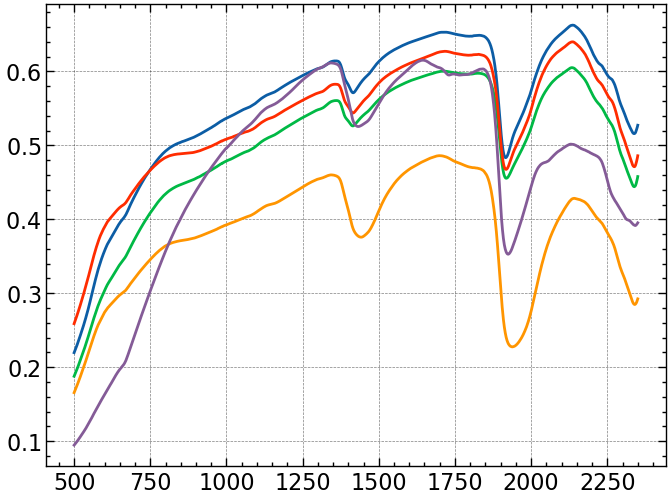

In [34]:
for i in range (0,5,1):
    spectra.iloc[i,:].plot()

## First Order Derivative

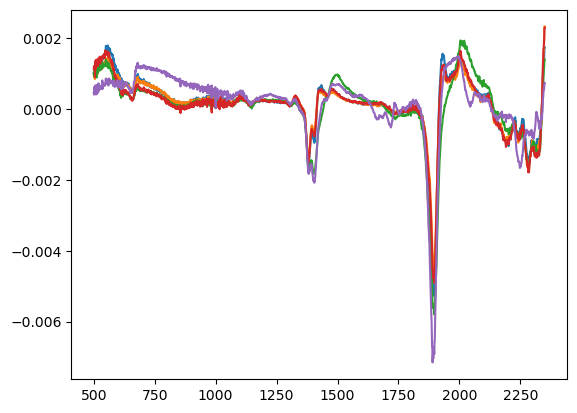

In [15]:
fod_spec = fod(spec2[51])

for i in range (0,5,1):
    fod_spec.iloc[i,:].plot()


In [16]:
fod1 = {}
for i in window_lengths:
    fod1[i] = filt_sg(fod_spec, i, 'sg1')
    
fod2 = {}
for i in window_lengths:
    fod2[i] = filt_sg(fod_spec, i, 'sg2') 

In [17]:
# smoothing the clipped fod spectra using sgsmooth

smth_fod = sgsmooth (fod_spec, 3)

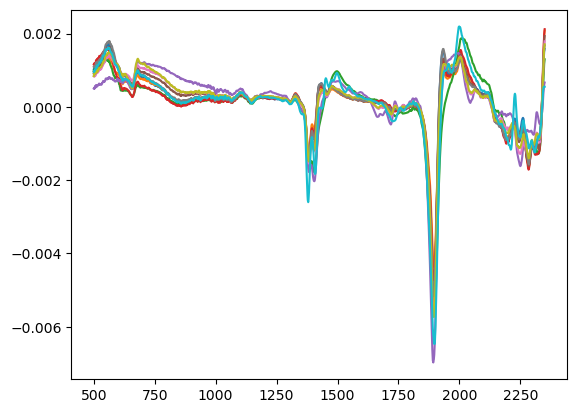

In [18]:
for i in range (0,10,1):
    smth_fod.iloc[i,:].plot()

## Continuum Removal

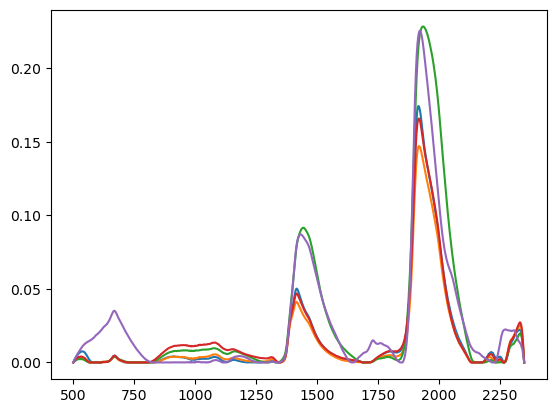

In [19]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,5,1):
    cr_spec.iloc[i,:].plot()
    

In [20]:
cr1 = {}
for i in window_lengths:
    cr1[i] = filt_sg(cr_spec, i, 'sg1')
    
cr2 = {}
for i in window_lengths:
    cr2[i] = filt_sg(cr_spec, i, 'sg2')  
 

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [21]:
sampled_spec = {}
for w in nbands_sampling:
    sampled_spec[w] = resample_spectra (spec2[51], w)

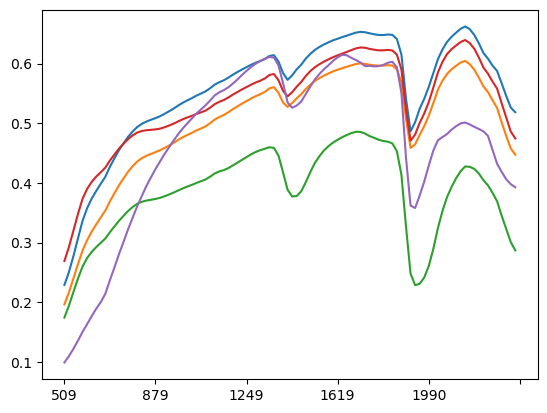

In [22]:
for i in range (0,5,1):
    sampled_spec[100].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [23]:
sampled_cr = {}
for w in nbands_sampling:
    sampled_cr[w] = resample_spectra (cr_spec, w)

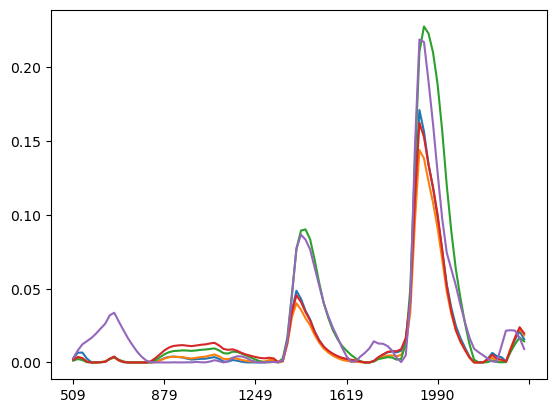

In [24]:
for i in range (0,5,1):
    sampled_cr[100].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [25]:
sampled_fod = {}
for w in nbands_sampling:
    sampled_fod[w] = resample_spectra (smth_fod, w)

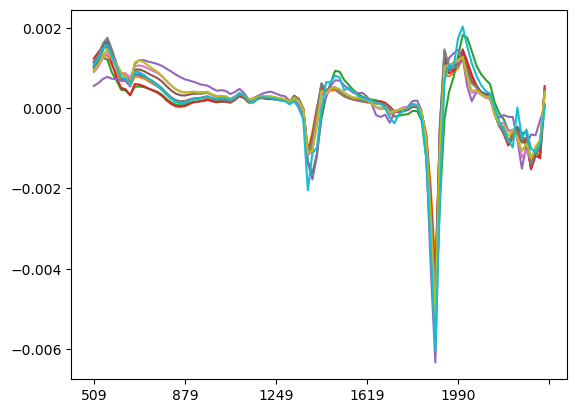

In [26]:
for i in range (0,10,1):
    sampled_fod[100].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [27]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = smth_fod.iloc[sample,:]*100
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 210,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=105, description='sample', max=210), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

# Step 1b: Target  Preprocessing (Outliers removal and Normalization)

In [28]:
df = pd.read_csv('uae.csv')
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(clean_lab,target_names) 


# --- TODO : Also define and Use other normalisation methods ----
def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


## Correlation between wavelengths and Targets

In [29]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(smth_fod, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.7, 0.7])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)


interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [35]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.2

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spec2[51].copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spec2[51].copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For sand :test size = 0.2 	 min bin error= 15.0 	 at randome state = 2
For silt :test size = 0.2 	 min bin error= 15.0 	 at randome state = 23
For clay :test size = 0.2 	 min bin error= 22.5 	 at randome state = 18
For TOC :test size = 0.2 	 min bin error= 15.0 	 at randome state = 20
After Normalization:
For sand :test size = 0.2 	 min bin error= 30.0 	 at randome state = 3
For silt :test size = 0.2 	 min bin error= 25.0 	 at randome state = 2
For clay :test size = 0.2 	 min bin error= 20.0 	 at randome state = 18
For TOC :test size = 0.2 	 min bin error= 30.0 	 at randome state = 10


# Step 3: Parameters for Best Model Fit 

## PLSR

In [36]:

from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
    r2L = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = iqrp(y_pred, y_test)
        r2_test = r2_score(y_test, y_pred)
#       rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
               
        iqrpL.append(iqrp_test)
        r2L.append(r2_test)
#         rpdL.append(rpd_test)
        
        
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
    
    R2 = max(r2L)
    n_r2 = r2L.index(R2)+1    

#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
#    print('IQRP :', IQRP,  'R2 :', R2,  'RPD:', RPD, '>>> n_comp: ', n_iqrp, n_r2, n_rpd)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [37]:
import os
os.system('say "your program has finished"')
import time

In [38]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [39]:
max_n_comp = 6

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        
        if t == 'sand' and m == 'mult':
            os.system('say "tree for multilinear running on sand"')
            print('tree for multilinear running on sand')
        if t == 'silt' and m == 'mult':
            os.system('say "tree for multilinear running on silt"')
            print('tree for multilinear running on silt')
        if t == 'clay' and m == 'mult':
            os.system('say "tree for multilinear running on clay"')
            print('tree for multilinear running on clay')
        if t == 'TOC' and m == 'mult':
            os.system('say "tree for multilinear running on TOC"')
            print('tree for multilinear running on TOC')
            
        if t == 'sand' and m == 'plsr':
            os.system('say "tree for plsr running on sand"')
            print('tree for plsr running on sand')
        if t == 'silt' and m == 'plsr':
            os.system('say "tree for plsr running on silt"')
            print('tree for plsr running on silt')
        if t == 'clay' and m == 'plsr':
            os.system('say "tree for plsr running on clay"')
            print('tree for plsr running on clay')
        if t == 'TOC' and m == 'plsr':
            os.system('say "tree for plsr running on TOC"')
            print('tree for plsr running on TOC')
            
        if t == 'sand' and m == 'randomforest':
            os.system('say "tree for randomforest running on sand"')
            print('tree for randomforest running on sand')
        if t == 'silt' and m == 'randomforest':
            os.system('say "tree for randomforest running on silt"')
            print('tree for randomforest running on silt')
        if t == 'clay' and m == 'randomforest':
            os.system('say "tree for randomforest running on clay"')
            print('tree for randomforest running on clay')
        if t == 'TOC' and m == 'randomforest':
            os.system('say "tree for randomforest running on TOC"')    
            print('tree for randomforest running on TOC')
            
        if t == 'sand' and m == 'cubist':
            os.system('say "tree for cubist running on sand"')
            print('tree for cubist running on sand')
        if t == 'silt' and m == 'cubist':
            os.system('say "tree for cubist running on silt"')
            print('tree for cubist running on silt')
        if t == 'clay' and m == 'cubist':
            os.system('say "tree for cubist running on clay"')
            print('tree for cubist running on clay')
        if t == 'TOC' and m == 'cubist':
            os.system('say "tree for cubist running on TOC"')
            print('tree for cubist running on TOC')
            
        if t == 'sand' and m == 'svr':
            os.system('say "tree for svr running on sand"')
            print('tree for svr running on sand')
        if t == 'silt' and m == 'svr':
            os.system('say "tree for svr running on silt"')
            print('tree for svr running on silt')
        if t == 'clay' and m == 'svr':
            os.system('say "tree for svr running on clay"')
            print('tree for svr running on clay')
        if t == 'TOC' and m == 'svr':
            os.system('say "tree for svr running on TOC"')
            print('tree for svr running on TOC')
            
        if t == 'sand' and m == 'ridge':
            os.system('say "tree for ridge running on sand"')
            print('tree for ridge running on sand')
        if t == 'silt' and m == 'ridge':
            os.system('say "tree for ridge running on silt"')
            print('tree for ridge running on silt')
        if t == 'clay' and m == 'ridge':
            os.system('say "tree for ridge running on clay"')
            print('tree for ridge running on clay')
        if t == 'TOC' and m == 'ridge':
            os.system('say "tree for ridge running on TOC"')
            print('tree for ridge running on TOC')
            
            
        if t == 'sand' and m == 'gbrt':
            os.system('say "tree for gbrt running on sand"')
            print('tree for gbrt running on sand')
        if t == 'silt' and m == 'gbrt':
            os.system('say "tree for gbrt running on silt"')
            print('tree for gbrt running on silt')
        if t == 'clay' and m == 'gbrt':
            os.system('say "tree for gbrt running on clay"')
            print('tree for gbrt running on clay')
        if t == 'TOC' and m == 'gbrt':
            os.system('say "tree for gbrt running on TOC"')
            print('tree for gbrt running on TOC')     
                 
            
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    
                    #---- following case : either sampling or decision tree methods--
                    #---- in this case select appropriate sampled spectrum -------
                    if n!=0 or m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                        #------ case: sampling required-----------------------
                        Y = tree[t][tp][n][p]
                        
                        #------ setting spec to appropriate sampled spectra----
                        if p == 'none':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_spec[n]
                        
                        elif p == 'fod':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_fod[n]
                                
                        else:  
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_cr[n]
                        
                        #---- target selection and normalization ---
                        if tp == 'none':
                            y = T[target_names.index(t)]
                            rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                        else:
                            y = NT[target_names.index(t)]
                            rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                            #print('one more target set')
                            
                        #---- performing train-test split----------------------
                        X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                        #----- PLSR: best parameters, fitting, and prediction
                        if m == 'plsr':
                            n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                            #print('one more n_comp', n_com)
                            Model = PLSRegression(n_components=n_com, scale=True)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test, copy=True)
                            yhat_pred = Model.predict(X_train, copy=True)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['n_comp'] = n_com
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                        #----- MULTILINEAR:  fitting, and prediction---------- 
                        if m == 'mult':
                            Model = linear_model.LinearRegression()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                        #----- RANDOM_FOREST:   fitting, and prediction---------- 
                        if m == 'randomforest': 
                            Model = RandomForestRegressor(random_state= 20)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                       
                       #----- CUBIST REGRESSION:    fitting and prediction---------
                        if m == 'cubist':
                            Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                      #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                        if m == 'svr': 
                            Model = SVR()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                     
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                        if m == 'ridge': 
                            Model = KernelRidge()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                            
                   #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                        if m == 'gbrt': 
                            Model = GradientBoostingRegressor()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                      
                            
                            
                    #---- following case: no sampling needed and model is not tree based methods e.g. randomforest ---    
                    else: 
                        for sg in sg_filters:
                            tree[t][tp][n][p][sg] ={}
                            for w in window_lengths:
                                tree[t][tp][n][p][sg][w]={}
                                Y = tree[t][tp][n][p][sg][w]
                                
                                # -- optimal train test split----------------------------------------
                            
                                # -- deciding the smoothed spectra in present branch ---
                                if sg == 'sg1':
                                    spec = spec1[w]
                                else:
                                    spec = spec2[w]
                                
                                # -- preprocessing the spectra ------
                    
                                #--- no preprocessing ---------------
                                if p == 'none':
                                    spec = spec
                                
                                #--- first order derivative + smoothing------    
                                elif p == 'fod':
                                    if sg == 'sg1':
                                        spec = fod1[w]
                                    else:
                                        spec = fod2[w]
                                    #print('fod for one more case')
                                
                                #--- continuum removal + smoothing---------    
                                else: 
                                    if sg == 'sg1':
                                        spec = cr1[w]
                                    else:
                                        spec = cr2[w]
                                    #print('cr for one more case')
                            
                                
                                #---- target selection and normalization ---
                                if tp == 'none':
                                    y = T[target_names.index(t)]
                                    rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                                else:
                                    y = NT[target_names.index(t)]
                                    rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                                    #print('one more target set')
                            
                                #---- performing train-test split----------------------
                                X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                                
                                #----- PLSR: best parameters, fitting, and prediction
                                if m == 'plsr':
                                    n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                                    #print('one more n_comp', n_com)
                                    Model = PLSRegression(n_components=n_com, scale=True)
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test, copy=True)
                                    yhat_pred = Model.predict(X_train, copy=True)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                    Y['n_comp'] = n_com
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                                #----- MULTILINEAR:  fitting, and prediction---------- 
                                if m == 'mult':
                                    Model = linear_model.LinearRegression()
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                


                    
                                #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                                if m == 'svr': 
                                    Model = SVR(kernel = 'poly', degree =3, C = 0.0001)
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred  
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                    
                         
                         #--------- RIDGE REGRESSION: fitting and prediction------------------
                                if m == 'ridge': 
                                    Model = KernelRidge()
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred 
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                      
     
    
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Mtree initialisation (do not run below code every time)

In [40]:
Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [41]:
Mtree['plsr'] = build_tree_for ('plsr')

tree for plsr running on sand
tree for plsr running on silt
tree for plsr running on clay
tree for plsr running on TOC
End time - Start time = 127.39276885986328


### Multiple Linear Regression Branch

In [42]:
Mtree['mult'] = build_tree_for ('mult')

tree for multilinear running on sand
tree for multilinear running on silt
tree for multilinear running on clay
tree for multilinear running on TOC
End time - Start time = 28.229124069213867


### Random Forest Branch

In [43]:
Mtree['randomforest'] = build_tree_for ('randomforest')

tree for randomforest running on sand
tree for randomforest running on silt
tree for randomforest running on clay
tree for randomforest running on TOC
End time - Start time = 209.06787753105164


### SVM Branch

In [44]:
Mtree['svr'] = build_tree_for ('svr')

tree for svr running on sand
tree for svr running on silt
tree for svr running on clay
tree for svr running on TOC
End time - Start time = 42.369226694107056


### GBRT Branch

In [45]:
Mtree['gbrt'] = build_tree_for ('gbrt')

tree for gbrt running on sand
tree for gbrt running on silt
tree for gbrt running on clay
tree for gbrt running on TOC
End time - Start time = 149.01844668388367


### Ridge Regression Branch

In [46]:
Mtree['ridge'] = build_tree_for ('ridge')

tree for ridge running on sand
tree for ridge running on silt
tree for ridge running on clay
tree for ridge running on TOC
End time - Start time = 25.04943299293518


### Cubist Branch

In [47]:
Mtree['cubist'] = build_tree_for ('cubist')

tree for cubist running on sand


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on silt


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on clay


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on TOC


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

End time - Start time = 91.08937454223633


## Best of all worlds

In [48]:
def best_model_parameters (Mtree, target, method):
    t=target
    m= method
    
    best_iqrp = 0
    best_sg ='NA'
    best_w = 'NA'
    best_n_comp = 'NA'
    
    if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    Y = Mtree[m][t][tp][n][p]
                    cur_iqrp = Y['iqrp_test']
                    if cur_iqrp > best_iqrp:
                        best_iqrp = cur_iqrp
                        best_tp = tp
                        best_n = n
                        best_p = p
                        
                            
    else:
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    for sg in sg_filters:
                        for w in window_lengths:
                            if n == 0:
                                Y = Mtree[m][t][tp][n][p][sg][w]
                            else:
                                Y = Mtree[m][t][tp][n][p]
                            cur_iqrp = Y['iqrp_test']
                            if cur_iqrp > best_iqrp:
                                best_iqrp = cur_iqrp
                                best_tp = tp
                                best_n = n
                                best_p = p
                                best_sg = sg
                                best_w = w
                                if m == 'plsr':
                                    best_n_comp = Y['n_comp']
    param_list = ['IQRP:', np.round(best_iqrp,2), 'pSpec:', best_p, 'bands:', best_n, 'pTar:', best_tp, 'filt:', best_sg, 'win:', best_w, 'best_n_comp: ', best_n_comp]                                 
    return (param_list)                                
    

In [49]:
param_list = best_model_parameters (Mtree, 'sand', 'randomforest')
print(param_list)

['IQRP:', 2.01, 'pSpec:', 'fod', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [50]:
param_list = best_model_parameters (Mtree, 'sand', 'plsr')
print(param_list)

['IQRP:', 1.62, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 3]


In [51]:
param_list = best_model_parameters (Mtree, 'sand', 'cubist')
print(param_list)

['IQRP:', 1.52, 'pSpec:', 'none', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [52]:
param_list = best_model_parameters (Mtree, 'sand', 'mult')
print(param_list)

['IQRP:', 1.64, 'pSpec:', 'none', 'bands:', 10, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [53]:
param_list = best_model_parameters (Mtree, 'sand', 'ridge')
print(param_list)

['IQRP:', 1.49, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [54]:
param_list = best_model_parameters (Mtree, 'sand', 'svr')
print(param_list)

['IQRP:', 1.41, 'pSpec:', 'none', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [55]:
param_list = best_model_parameters (Mtree, 'sand', 'gbrt')
print(param_list)

['IQRP:', 2.0, 'pSpec:', 'fod', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [56]:
param_list = best_model_parameters (Mtree, 'clay', 'plsr')
print(param_list)

['IQRP:', 1.7, 'pSpec:', 'fod', 'bands:', 100, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 2]


In [57]:
param_list = best_model_parameters (Mtree, 'clay', 'randomforest')
print(param_list)

['IQRP:', 1.59, 'pSpec:', 'fod', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [58]:
param_list = best_model_parameters (Mtree, 'clay', 'mult')
print(param_list)

['IQRP:', 1.68, 'pSpec:', 'fod', 'bands:', 5, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [59]:
param_list = best_model_parameters (Mtree, 'clay', 'ridge')
print(param_list)

['IQRP:', 1.66, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [60]:
param_list = best_model_parameters (Mtree, 'clay', 'svr')
print(param_list)

['IQRP:', 1.64, 'pSpec:', 'fod', 'bands:', 500, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [61]:
param_list = best_model_parameters (Mtree, 'clay', 'cubist')
print(param_list)

['IQRP:', 1.72, 'pSpec:', 'none', 'bands:', 200, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [62]:
param_list = best_model_parameters (Mtree, 'clay', 'gbrt')
print(param_list)

['IQRP:', 1.71, 'pSpec:', 'fod', 'bands:', 50, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [63]:
param_list = best_model_parameters (Mtree, 'silt', 'plsr')
print(param_list)

['IQRP:', 1.47, 'pSpec:', 'fod', 'bands:', 10, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 4]


In [64]:
param_list = best_model_parameters (Mtree, 'silt', 'randomforest')
print(param_list)

['IQRP:', 1.61, 'pSpec:', 'fod', 'bands:', 500, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [65]:
param_list = best_model_parameters (Mtree, 'silt', 'mult')
print(param_list)

['IQRP:', 1.44, 'pSpec:', 'fod', 'bands:', 10, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [66]:
param_list = best_model_parameters (Mtree, 'silt', 'ridge')
print(param_list)

['IQRP:', 1.39, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [67]:
param_list = best_model_parameters (Mtree, 'silt', 'svr')
print(param_list)

['IQRP:', 1.49, 'pSpec:', 'none', 'bands:', 5, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [68]:
param_list = best_model_parameters (Mtree, 'silt', 'cubist')
print(param_list)

['IQRP:', 1.54, 'pSpec:', 'continuum', 'bands:', 0, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [69]:
param_list = best_model_parameters (Mtree, 'silt', 'gbrt')
print(param_list)

['IQRP:', 1.55, 'pSpec:', 'fod', 'bands:', 10, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [70]:
param_list = best_model_parameters (Mtree, 'TOC', 'plsr')
print(param_list)

['IQRP:', 1.35, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 3]


In [71]:
param_list = best_model_parameters (Mtree, 'TOC', 'randomforest')
print(param_list)

['IQRP:', 1.41, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [72]:
param_list = best_model_parameters (Mtree, 'TOC', 'mult')
print(param_list)

['IQRP:', 1.28, 'pSpec:', 'continuum', 'bands:', 10, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [73]:
param_list = best_model_parameters (Mtree, 'TOC', 'ridge')
print(param_list)

['IQRP:', 1.13, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [74]:
param_list = best_model_parameters (Mtree, 'TOC', 'svr')
print(param_list)

['IQRP:', 1.16, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [75]:
param_list = best_model_parameters (Mtree, 'TOC', 'cubist')
print(param_list)

['IQRP:', 1.3, 'pSpec:', 'continuum', 'bands:', 500, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [76]:
param_list = best_model_parameters (Mtree, 'TOC', 'gbrt')
print(param_list)

['IQRP:', 1.48, 'pSpec:', 'fod', 'bands:', 200, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


## Plotting Model Accuracy (ipywidgets)

In [77]:
def plot_model_acc (target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    sg = smth_filt
    w = window_len
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    if n!=0 or m == 'randomforest' or m =='cubist' or m == 'gbrt':
        Y = Mtree[m][t][tp][n][p]
    else: 
        Y = Mtree[m][t][tp][n][p][sg][w]
    
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    iqrp_test = iqrp(y_pred, y_test)
    r2_test = r2_score(y_test, y_pred)
    rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
    
    iqrp_train = iqrp(yhat_pred, y_train)
    r2_train = r2_score(y_train, yhat_pred)
    rpd_train = y_train.std()/np.sqrt(mean_squared_error(y_train, yhat_pred))
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[0].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[1].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 12)
        
    

In [79]:
ipywidgets.interact(plot_model_acc, target = target_names, method = ml_methods, smth_filt = sg_filters, 
                    window_len = window_lengths, spec_preprocessing = prepare_spec, n_bands = nbands_sampling, 
                    target_preprocessing = prepare_target)

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_model_acc(target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing)>

In [80]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svm']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']